In [320]:
import numpy as np
import pandas as pd
import pyreadr 
import networkx as nx
import re
from scipy import sparse
import matplotlib.pyplot as plt
import src.Aux_functions as aux
import jax.numpy as jnp


In [321]:
# Load data
all_schools = pyreadr.read_r('37070-0001-Data.rda')
all_schools = pd.DataFrame(all_schools['da37070.0001'])
all_schools

,SCHID,UID,SCHTREAT,SCHRB,ID,TREAT,STRB,SID1,SID3,SID4,...,AM_F,PI_M,PI_F,MU_M,MU_F,ROW_TOTAL,FREE_LUNCH,REDUCED_LUNCH,LEP,MIGRANT
0,1.0,100001.0,(1) Treatment school (Roots meetings 2012-2013),3,1,(0) Not treatment or control,0.0,5114,5114,5114,...,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(029) 281-290,(008) 71-80,(005) 41-50,(001) 0-10,[MASKED BY ICPSR]
1,1.0,100002.0,(1) Treatment school (Roots meetings 2012-2013),3,2,(2) Control,4.0,5108,5108,5108,...,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(029) 281-290,(008) 71-80,(005) 41-50,(001) 0-10,[MASKED BY ICPSR]
2,1.0,100003.0,(1) Treatment school (Roots meetings 2012-2013),3,3,(0) Not treatment or control,0.0,5100,5100,5100,...,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(029) 281-290,(008) 71-80,(005) 41-50,(001) 0-10,[MASKED BY ICPSR]
3,1.0,100004.0,(1) Treatment school (Roots meetings 2012-2013),3,4,(0) Not treatment or control,0.0,5101,5101,5101,...,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(029) 281-290,(008) 71-80,(005) 41-50,(001) 0-10,[MASKED BY ICPSR]
4,1.0,100005.0,(1) Treatment school (Roots meetings 2012-2013),3,5,(0) Not treatment or control,0.0,5087,5087,5087,...,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(029) 281-290,(008) 71-80,(005) 41-50,(001) 0-10,[MASKED BY ICPSR]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24466,60.0,6000670.0,(1) Treatment school (Roots meetings 2012-2013),11,670,NaN,NaN,13897,13897,13897,...,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(071) 701-710,(004) 31-40,(002) 11-20,(001) 0-10,[MASKED BY ICPSR]
24467,60.0,6000671.0,(1) Treatment school (Roots meetings 2012-2013),11,671,NaN,NaN,14054,14054,14054,...,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(071) 701-710,(004) 31-40,(002) 11-20,(001) 0-10,[MASKED BY ICPSR]
24468,60.0,6000672.0,(1) Treatment school (Roots meetings 2012-2013),11,672,NaN,NaN,13985,13985,13985,...,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(071) 701-710,(004) 31-40,(002) 11-20,(001) 0-10,[MASKED BY ICPSR]
24469,60.0,6000673.0,(1) Treatment school (Roots meetings 2012-2013),11,673,NaN,NaN,,,,...,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(071) 701-710,(004) 31-40,(002) 11-20,(001) 0-10,[MASKED BY ICPSR]


In [363]:
# Clean data
# Remove all observations for which both the school-id and the block-number of the school are unknown (1.14% of the observations, or 280 observations)
all_schools['ID'] = pd.to_numeric(all_schools['ID'], errors='coerce').fillna(0.0)
all_schools['SCHRB'] = pd.to_numeric(all_schools['SCHRB'], errors='coerce')
# all_schools = all_schools[~all_schools['SCHRB'].isna() & (all_schools['ID'] != 999.0)]
all_schools = all_schools[~all_schools['SCHRB'].isna() &
                          (all_schools['ID'] != 999.0) & 
                          (all_schools['ID'] != 0.0) &
                          (all_schools['UID'] != 100284.0)] 

# Create unique id
all_schools['unique_id'] = all_schools['SCHID']*1000 + all_schools['ID']
all_schools['unique_id'] = all_schools['unique_id'].astype(int)

# Convert treatment variables to numeric
def extract_numeric(x):
    match = re.search(r'\(?([0-9,.]+)\)?', str(x))
    return float(match.group(1)) if match else np.nan

all_schools['TREAT_NUMERIC'] = all_schools['TREAT'].apply(extract_numeric).fillna(0.0).astype(int)
all_schools['SCHTREAT_NUMERIC'] = all_schools['SCHTREAT'].apply(extract_numeric).fillna(0.0).astype(int)
# 
# # Create indicator of eligible units
all_schools['ELIGIBLE'] = (all_schools['TREAT_NUMERIC'] != 0.0).astype(int)
all_schools['ELIGIBLE'] = all_schools['ELIGIBLE'].fillna(0)
# 
# # Numeric version of OUTOFBLOCK
all_schools['OUTOFBLOCK_NUMERIC'] = all_schools['OUTOFBLOCK'].apply(extract_numeric).fillna(0.0).astype(int)
# 
# # Get numeric version of outcome (wearing orange band)
all_schools['WRISTOW2_NUMERIC'] = all_schools['WRISTOW2'].apply(extract_numeric).fillna(0.0).astype(int)

print(all_schools.shape)
all_schools.head(5)

(24182, 506)


,SCHID,UID,SCHTREAT,SCHRB,ID,TREAT,STRB,SID1,SID3,SID4,...,REDUCED_LUNCH,LEP,MIGRANT,unique_id,TREAT_NUMERIC,SCHTREAT_NUMERIC,ELIGIBLE,OUTOFBLOCK_NUMERIC,WRISTOW2_NUMERIC,is_ST_node
0,1.0,100001.0,(1) Treatment school (Roots meetings 2012-2013),3.0,1.0,(0) Not treatment or control,0.0,5114,5114,5114,...,(005) 41-50,(001) 0-10,[MASKED BY ICPSR],1001,0,1,0,0,0,1
1,1.0,100002.0,(1) Treatment school (Roots meetings 2012-2013),3.0,2.0,(2) Control,4.0,5108,5108,5108,...,(005) 41-50,(001) 0-10,[MASKED BY ICPSR],1002,2,1,1,0,0,1
2,1.0,100003.0,(1) Treatment school (Roots meetings 2012-2013),3.0,3.0,(0) Not treatment or control,0.0,5100,5100,5100,...,(005) 41-50,(001) 0-10,[MASKED BY ICPSR],1003,0,1,0,0,0,1
3,1.0,100004.0,(1) Treatment school (Roots meetings 2012-2013),3.0,4.0,(0) Not treatment or control,0.0,5101,5101,5101,...,(005) 41-50,(001) 0-10,[MASKED BY ICPSR],1004,0,1,0,0,1,1
4,1.0,100005.0,(1) Treatment school (Roots meetings 2012-2013),3.0,5.0,(0) Not treatment or control,0.0,5087,5087,5087,...,(005) 41-50,(001) 0-10,[MASKED BY ICPSR],1005,0,1,0,0,0,1


In [365]:
N_all = all_schools.shape[0]
N_elig = all_schools['ELIGIBLE'].sum()
print(N_all, N_elig)

24182 2943


In [386]:
# Get ST W1 network
# Get questionnaire
ST_cols = ['ST1', 'ST2', 'ST3', 'ST4', 'ST5', 'ST6', 'ST7', 'ST8', 'ST9', 'ST10']
ST_W1_df = all_schools[ST_cols].astype(float)

# Replace 999 with NaN as 999 is the code for missing values
for col in ST_cols:
     ST_W1_df[col][ST_W1_df[col] == 999] = np.nan

# Add SCHID * 1000 to survey data (to obtain edge list with `unique_id` values)  
for col in ST_cols:
    ST_W1_df[col] += all_schools['SCHID'] * 1000

valid_ids = set(all_schools['unique_id'])
print("len valid id = ", len(valid_ids))

# Get edges list
ST_W1_edgelist = []
for col in ST_W1_df.columns:
# for i in range(ST_W1_df.shape[0]):
    ST_W1_edgelist.extend(zip(all_schools['unique_id'], ST_W1_df[col]))

print("len edgelist = ", len(ST_W1_edgelist))

ST_W1_edgelist = [
    (int(a), int(b)) 
    for a, b in ST_W1_edgelist 
    if not np.isnan(a) and not np.isnan(b) 
    and int(a) in valid_ids and int(b) in valid_ids
    and int(a) != int(b)
]
# ST_W1_edgelist = [(int(a), int(b)) for a, b in ST_W1_edgelist if not np.isnan(a) and not np.isnan(b)]
# ST_W1_edgelist = [(int(a), int(b)) for a, b in ST_W1_edgelist if not (np.isnan(a) and np.isnan(b))]
print("len edgelist post = ", len(ST_W1_edgelist))
ST_unique_nodes = set(node for pair in ST_W1_edgelist for node in pair)
print("len unique nodes = ", len(ST_unique_nodes))
all_schools['is_ST_node'] = all_schools['unique_id'].isin(ST_unique_nodes).astype(int)
print("Proportion of ST nodes:", all_schools['is_ST_node'].mean())
isolated_nodes = set(all_schools['unique_id']) - ST_unique_nodes
print("Number of isolated nodes:", len(isolated_nodes))



C:\Users\bar21\AppData\Local\Temp\ipykernel_14868\2935341455.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ST_W1_df[col][ST_W1_df[col] == 999] = np.nan
C:\Users\bar21\AppData\Local\Temp\ipykernel_14868\2935341455.py:8: FutureWarning: C

len valid id =  24182
len edgelist =  241820
len edgelist post =  181057
len unique nodes =  23607
Proportion of ST nodes: 0.9762219832933587
Number of isolated nodes: 575


In [387]:
# Create graph
ST_W1_network = nx.Graph(ST_W1_edgelist)
node_sizes = [ST_W1_network.degree(node) for node in ST_W1_network.nodes()]
print(len(ST_W1_network.nodes()))
print(np.mean(node_sizes), np.min(node_sizes), np.max(node_sizes), np.median(node_sizes))
ST_nodes = set(ST_W1_network.nodes())
print(ST_nodes == ST_unique_nodes)
print("valid id in network sum = ",np.sum([node in ST_W1_network for node in valid_ids]))
print("st nodes in valid id sum = ", np.sum([node in valid_ids for node in ST_nodes]))

ST_eigen_cent = jnp.array([b for a,b in nx.eigenvector_centrality_numpy(ST_W1_network).items()])

ST_adj_matrix = nx.to_numpy_array(ST_W1_network)
print(ST_adj_matrix.shape)
print(type(ST_adj_matrix))
ST_adj_matrix[ST_adj_matrix > 1] = 1
np.fill_diagonal(ST_adj_matrix, 0)
ST_adj_matrix = jnp.array(ST_adj_matrix)

# ST_eigen_cent = aux.eigen_centrality(ST_adj_matrix)
print(np.mean(ST_eigen_cent), np.min(ST_eigen_cent), np.max(ST_eigen_cent), np.median(ST_eigen_cent))

ST_nodes_treatment = jnp.array((all_schools[all_schools['is_ST_node'] == 1]['TREAT_NUMERIC']==1).astype(int))
ST_zeigen = aux.zeigen_value(ST_nodes_treatment, ST_eigen_cent , ST_adj_matrix)
print(np.mean(ST_zeigen), np.min(ST_zeigen), np.max(ST_zeigen), np.median(ST_zeigen))

n_expos = jnp.dot(ST_adj_matrix, ST_nodes_treatment) / jnp.sum(ST_adj_matrix, axis=1) 
print(np.mean(n_expos), np.min(n_expos), np.max(n_expos), np.median(n_expos), np.std(n_expos))

# plt.scatter(ST_eigen_cent, ST_eig_cen)

# print((all_schools[all_schools['unique_id'].isin(ST_nodes)]['unique_id'] == list(ST_nodes)).sum())
# print(all_schools[all_schools['unique_id'].isin(ST_nodes)]['unique_id'][0])
# print(list(ST_nodes)[0])
# all_schools[~all_schools['unique_id'].isin(ST_nodes)]
# plt.hist(node_sizes)
# nx.draw(ST_W1_network, node_color = all_schools["TREAT_NUMERIC"].tolist(), node_size=node_sizes, width=0.05)

23607
11.717456686576016 1 41 12.0
True
valid id in network sum =  23607
st nodes in valid id sum =  23607
(23607, 23607)
<class 'numpy.ndarray'>
0.0007547253 -6.5140386e-16 0.17697088 1.9314492e-19
0.000763508 -8.523221e-16 0.31320262 0.0
0.06290364 0.0 1.0 0.04761905 0.080229394


In [388]:
subset_nodes = list(ST_nodes)[1:2000]
ST_subset = ST_W1_network.subgraph(subset_nodes)
schid_st = all_schools[all_schools['unique_id'].isin(subset_nodes)]['SCHID']

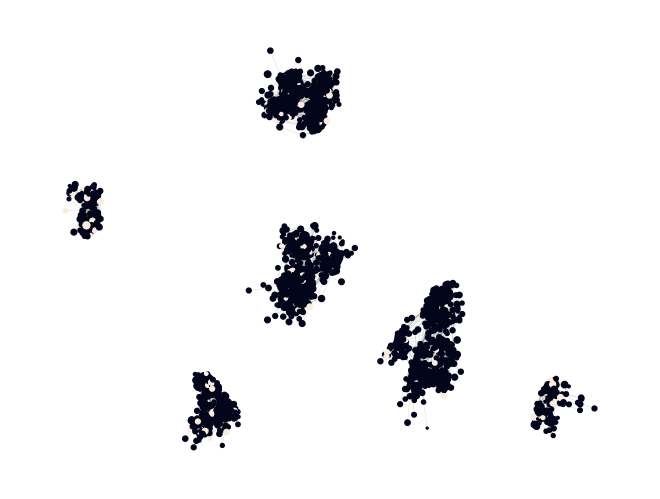

In [392]:
# nx.draw(ST_subset, node_color = schid_st, node_size=node_sizes[1:2000], width=0.05)
nx.draw(ST_subset, node_color = ST_nodes_treatment[1:2000], node_size=node_sizes[1:2000], width=0.05)

In [ ]:
# TODO: model each school network seperately (can be same model with different parameters)
# TODO: Think how to model the outcome model (what structrual assumptions) and what are the relevant causal estimands
# TODO: Think the outcome analysis should be limited to the eligible students only (due to positivity)
# Nonetheless, the network analysis should be done on the full network of each school (avoid network sampling)


In [413]:
# all_schools[all_schools['is_ST_node'] == 1][["SCHID","SCHTREAT_NUMERIC"]].value_counts()
(all_schools[all_schools['is_ST_node'] == 1 ]["SCHTREAT_NUMERIC"]*(all_schools[all_schools['is_ST_node'] == 1 ]["TREAT_NUMERIC"]==1)).sum()

728

(array([1.140e+02, 2.070e+02, 3.020e+02, 5.080e+02, 7.290e+02, 9.930e+02,
        1.192e+03, 1.336e+03, 1.510e+03, 2.135e+03, 2.499e+03, 2.382e+03,
        2.238e+03, 1.883e+03, 1.451e+03, 1.147e+03, 8.570e+02, 5.910e+02,
        4.330e+02, 3.210e+02, 2.400e+02, 1.540e+02, 1.140e+02, 8.700e+01,
        5.800e+01, 3.700e+01, 2.600e+01, 2.100e+01, 1.000e+01, 6.000e+00,
        6.000e+00, 6.000e+00, 2.000e+00, 7.000e+00, 4.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
        40., 41.]),
 <BarContainer object of 40 artists>)

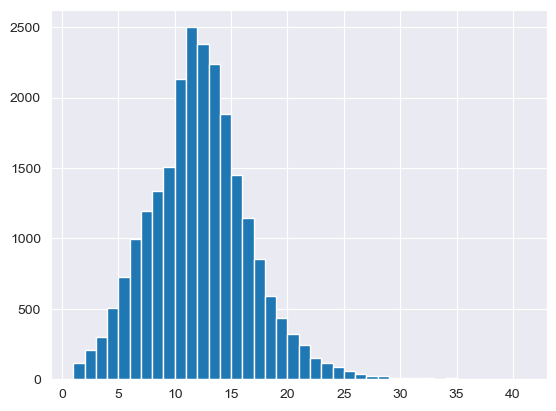

In [314]:
plt.hist(node_sizes, bins=40)

In [249]:
eigen_center = np.array(list(nx.eigenvector_centrality_numpy(ST_W1_network).values()))
print(np.mean(eigen_center), np.median(eigen_center), np.min(eigen_center), np.max(eigen_center))
print(nx.is_connected(ST_W1_network))
print(nx.number_connected_components(ST_W1_network))
print(nx.transitivity(ST_W1_network))


0.0007462484576679041 1.5770720666065805e-19 -5.9582104097801864e-15 0.1769232141523103
False
57
0.24375546229394712


KeyboardInterrupt: 

In [ ]:
# Get edges list
edgelist = []
for col in survey_df_min.columns:
    edgelist.extend(zip(all_schools_min['unique_id'], survey_df_min[col]))

# Add self-loops
edgelist.extend(zip(all_schools_min['unique_id'], all_schools_min['unique_id']))

# Remove NA
edgelist = [(int(a), int(b)) for a, b in edgelist if not np.isnan(a) and not np.isnan(b)]

# Create graph
either_peers_graph = nx.Graph(edgelist)

# Get adjacency matrix
adj_matrix_either = nx.to_numpy_array(either_peers_graph)

# Set values > 1 to 1 and diagonal to 0
adj_matrix_either[adj_matrix_either > 1] = 1
np.fill_diagonal(adj_matrix_either, 0)